In [17]:
import numpy
from PIL import Image
from os import listdir
def imagesList (folder):
    images=[]
    for filename in listdir(folder):
        img= Image.open(folder+filename).convert('RGB')
        img=numpy.array(img)               #
        images.append(img)               # Appending all images in 'images' list 
    return(images)

maps = imagesList("Map/")   
masks = imagesList("Masks/")

In [19]:
from skimage import exposure
import time
import matplotlib.pyplot as plt
def resizeImg (img):
    images_box=[]
    width, height, dim = img.shape
    chopsize = 250
    i=0
    for x0 in range(0, width-chopsize, chopsize):
        for y0 in range(0, height-chopsize, chopsize):
            img_crop = img[x0:(x0+chopsize),y0:(y0+chopsize),:]
            images_box.append(img_crop)
    return images_box

def equalizeHist(img):
    colors = ("g")
    channel_ids = (1)
    myCropImgMasks = numpy.asarray(exposure.equalize_hist(img[:, :, channel_ids]) * 255, dtype='uint8')
    return myCropImgMasks

def imgLabelize(img2,ind):
    width, height= img2.shape
    img = [[0 for i in range(width)] for j in range(height)] 
    for x0 in range(0, width):
        for y0 in range(0, height):  
            if img2[x0][y0] > ind:
                img[x0][y0] = 1
            else :
                img[x0][y0] = 0
    return img


myMasks = []
myInputMaps = []

for i in range (len(maps)):
    cropMasks = resizeImg(masks[i])
    cropMaps = resizeImg(maps[i])
    masksConstructor = []
    for j in range (len(cropMasks)):
        equalHistMasks = equalizeHist(cropMasks[j])
        labelizeMasks = imgLabelize(equalHistMasks,120)
        masksConstructor.append(labelizeMasks)
    print("DATABASE Progression : ", (i+1) / len(maps) * 100,"%")
    myMasks.append(masksConstructor)
    myInputMaps.append(cropMaps)
numpy.savetxt("myMasks.csv", myMasks, delimiter=",")
numpy.savetxt("myInputMaps.csv", myInputMaps, delimiter=",")

DATABASE Progression :  5.0 %
DATABASE Progression :  10.0 %
DATABASE Progression :  15.0 %
DATABASE Progression :  20.0 %
DATABASE Progression :  25.0 %
DATABASE Progression :  30.0 %
DATABASE Progression :  35.0 %
DATABASE Progression :  40.0 %
DATABASE Progression :  45.0 %
DATABASE Progression :  50.0 %
DATABASE Progression :  55.00000000000001 %
DATABASE Progression :  60.0 %
DATABASE Progression :  65.0 %
DATABASE Progression :  70.0 %
DATABASE Progression :  75.0 %
DATABASE Progression :  80.0 %
DATABASE Progression :  85.0 %
DATABASE Progression :  90.0 %
DATABASE Progression :  95.0 %
DATABASE Progression :  100.0 %


TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e')

In [27]:


import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers.convolutional import Conv2D

def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

X_train, X_test, y_train, y_test = train_test_split(myInputMaps, myMasks, 
                                                    train_size=0.6, 
                                              random_state=42)
print(myInputMaps[1][19].shape)
input_layer = [250,250,3]
output_layer = build_model(input_layer, 16)


output_layer.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = output_layer.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

(250, 250, 3)


ValueError: Layer conv2d_8 expects 1 inputs, but it received 3 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=250>, <tf.Tensor: shape=(), dtype=int32, numpy=250>, <tf.Tensor: shape=(), dtype=int32, numpy=3>]

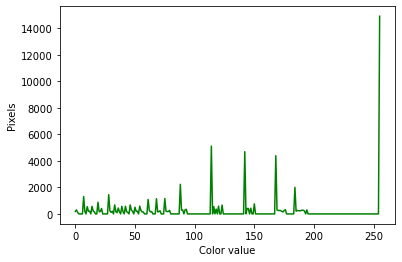

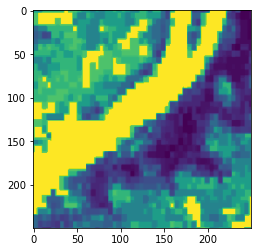

In [444]:
#myCropImgMasks = resizeImg(masks[11])
#myCropImgMaps = resizeImg(maps[11])
#print(myCropImgMaps[0].shape)

plt.plot(bin_edges[0:-1], histogram, color=colors)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()
plt.imshow(myCropImgMasks)

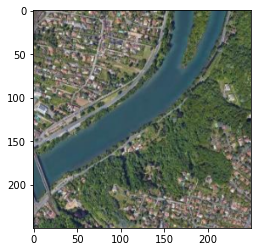

In [400]:
plt.imshow(myCropImgMaps[10])

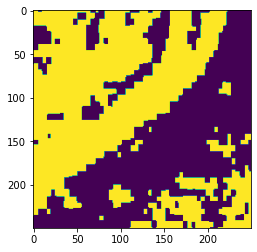

In [431]:

imgReturn = imgLabelize(myCropImgMasks,120)
plt.imshow(imgReturn)
